Define headers

In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Define Dataset

In [5]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import cv2
from PIL import Image

def get_ball_dicts():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4:69+4]
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
#             print(line_label)
            x = line_label.split()
#             print(x)
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

def get_ball_dicts_grayscale():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images_grayscale.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4+1:69+4+1]
#         print(filename)
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
#             print(line_label)
            x = line_label.split()
#             print(x)
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("Ball_train", lambda:get_ball_dicts())
MetadataCatalog.get("Ball_train").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train")


DatasetCatalog.register("Ball_train_bw", lambda:get_ball_dicts_grayscale())
MetadataCatalog.get("Ball_train_bw").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train_bw")

Confirm if datasets works

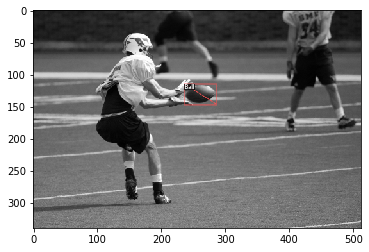

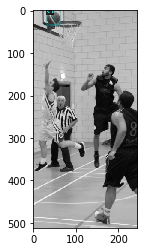

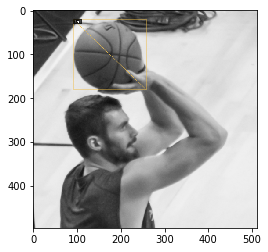

In [6]:
import random 
import matplotlib.pyplot as plt
dataset_dicts = get_ball_dicts_grayscale()
ball_metadata = MetadataCatalog.get("Ball_train_bw")
# print (dataset_dicts)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ball_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image()[:, :, ::-1])
    


In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import torch
torch.cuda.set_device(2)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("Ball_train_bw",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5001    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[02/03 14:57:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[02/03 14:57:59 d2.data.build]: Removed 0 images with no usable annotations. 3480 images left.
[02/03 14:57:59 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    Ball    | 6845         |
|            |              |
[02/03 14:57:59 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[02/03 14:57:59 d2.data.build]: Using training sampler TrainingSampler
[02/03 14:58:00 d2.engine.train_loop]: Starting training from iteration 5001
[02/03 14:58:00 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


OrderedDict()

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ball_train", )
predictor = DefaultPredictor(cfg)

(288, 384, 3)

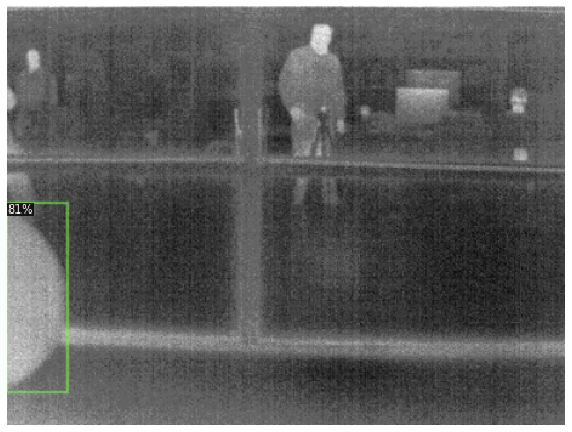

In [9]:
im = cv2.imread("/home/danielarato/ball_detection/Datasets/train/bag_2cam/thermic/1579790238028925357.png")

outputs = predictor(im)
# print(outputs["instances"].scores, outputs["instances"].pred_boxes)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
_, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
ax.imshow(v.get_image()[:, :, ::-1])

results=outputs["instances"].to("cpu")
# results.pred_boxes.tensor[0].numpy()
im.shape

(1440, 1920, 3)

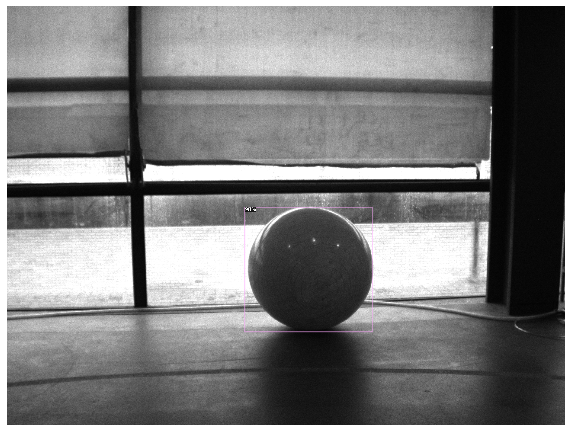

In [10]:
im_rgb = cv2.imread("/home/danielarato/ball_detection/Datasets/train/bag2/RGB/1580394991253331379.png")

outputs2 = predictor(im_rgb)

v = Visualizer(im_rgb[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs2["instances"].to("cpu"))
_, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
ax.imshow(v.get_image()[:, :, ::-1])
im_rgb.shape

In [11]:
# cameraMatrix=[[708.30536, 0, 170.51079],
#  [0, 714.59424, 130.0705],
#  [0, 0, 1]]
from detectron2.utils.visualizer import ColorMode
import numpy as np
import time

d_real=0.63 *1000#m

cameraMatrix_IR=np.array([[725.790155, 0, 191.397201],
[0, 733.580771, 149.464123],
[0, 0, 1]])

print(cameraMatrix_IR)

fx=cameraMatrix_IR[0][0]
fy=cameraMatrix_IR[1][1]
cx=cameraMatrix_IR[0][2]
cy=cameraMatrix_IR[1][2]
print(fx,fy,cx,cy)

[[725.790155   0.       191.397201]
 [  0.       733.580771 149.464123]
 [  0.         0.         1.      ]]
725.790155 733.580771 191.397201 149.464123


In [13]:

cameraMatrix_RGB=np.array([[2168.684845,0,965.374725],
[0,2180.313918,699.133011],
[0,0,1]])

# cameraMatrix_mono=np.array([[2477.329635,0,1164.282877],
# [0,2488.879238,786.821399],
# [0,0,1]])

cameraMatrix_RGB=cameraMatrix_mono

print(cameraMatrix_RGB)

fx_rgb=cameraMatrix_RGB[0][0]
fy_rgb=cameraMatrix_RGB[1][1]
cx_rgb=cameraMatrix_RGB[0][2]
cy_rgb=cameraMatrix_RGB[1][2]
print(fx_rgb,fy_rgb,cx_rgb,cy_rgb)

[[2.47732964e+03 0.00000000e+00 1.16428288e+03]
 [0.00000000e+00 2.48887924e+03 7.86821399e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
2477.329635 2488.879238 1164.282877 786.821399


-0.8864603892795916 0.485191576929186 4.238445894246726
-0.8346465674542347 0.4796921724867489 4.162646277810477
-0.7993428223570763 0.44502410371513523 4.0505933711340205
-0.551227756462176 0.3619252952304212 3.3558553249625866
-0.5148995241435533 0.35485471376039335 3.301981336661399
-0.47702791751701085 0.3646314238209026 3.3163931875338166
-0.0610074433174768 0.4041816600412429 3.1838614931606477
-0.008486679715529051 0.39529735286232237 3.281240840042827
0.024310336065507806 0.42132115182846486 3.259718785250843
0.4275607328416798 0.43795959970057613 3.2109932014808087
0.4859145585603079 0.42857464717354765 3.2808895670699068
0.517600408894715 0.42707245898082064 3.261221918913167
0.5581676805164106 0.42918961256493426 3.2230375214891684
0.9576854374589148 0.4554157015739024 3.3383090061363063
1.0160430809738492 0.469873158528117 3.4078493768486604
1.031102088954095 0.4503445450782759 3.1935936759873567
1.3544127276310582 0.4366960877160195 3.2854619903516293
1.4132170410351228 0.

/home/danielarato/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.8863998979240655 0.5152525348823166 3.485097924187863
2.484840125025976 0.6494034699314988 4.034949896339858
2.529098532996959 0.6366175218600151 4.08097866474322
2.6048956490544914 0.6570453539787794 4.166419012008882
2.14971215035187 0.5966868360799608 3.7203240536559705
1.956551120492545 0.6283545980974392 3.4554954838200476
2.041738576448396 0.6050595374138604 3.60112680028201
1.9011765871532702 0.4871648496636898 3.5231594243562228
1.9475102009840402 0.5640605482429806 3.638752853049432
1.8392071744961804 0.5070698805111635 3.466831385294118
1.7396217333174724 0.48276116610522635 3.4178575590334574
1.7320240083969962 0.48212023649843017 3.4442334733648012
1.7053261600191711 0.49176055229376103 3.4053249504796472
1.555669883285769 0.4715454520619584 3.320825266849671
1.5574948177343717 0.4778239378307748 3.331776348541402
1.500674549920934 0.42864065791364026 3.2471698925619834
1.4238792076062399 0.4483449949788911 3.2907537255449375
1.397670899974187 0.44289253077254964 3.254641

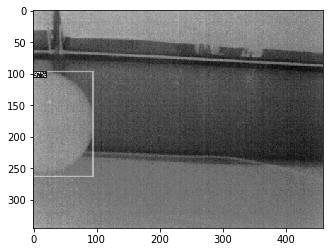

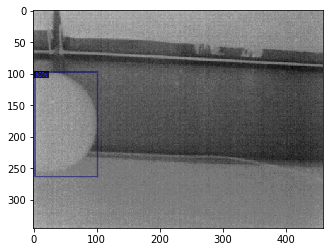

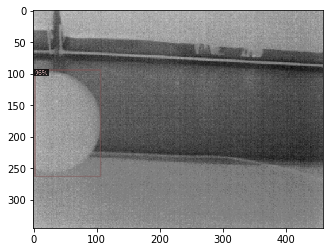

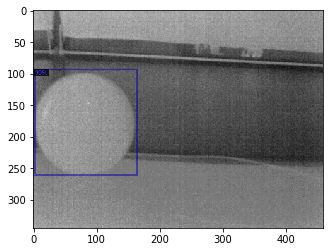

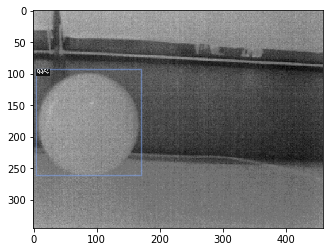

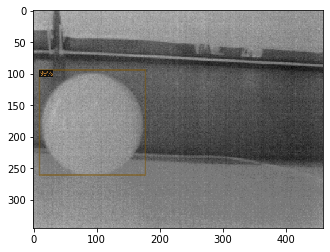

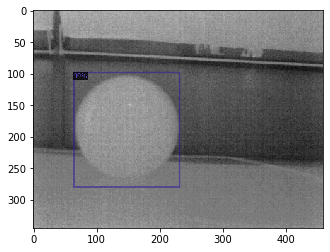

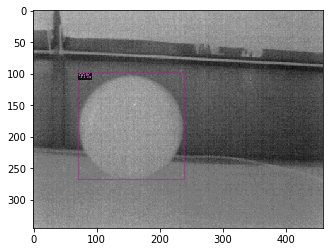

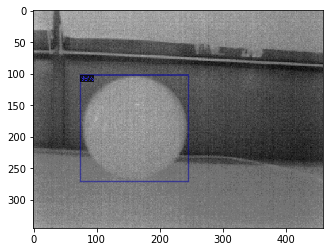

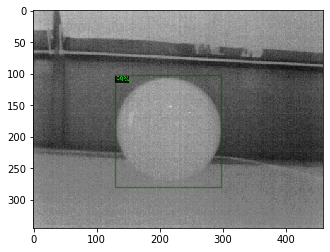

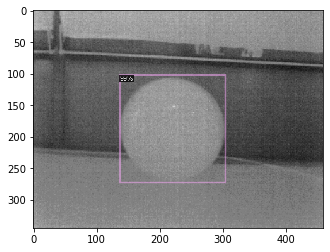

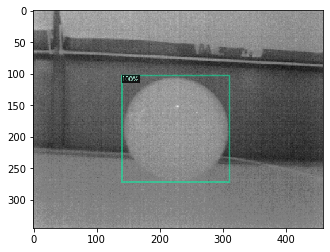

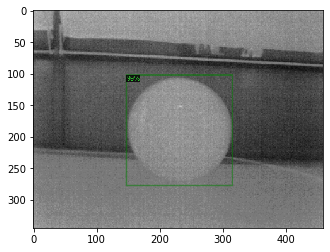

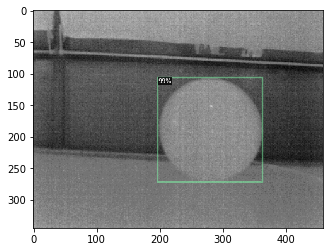

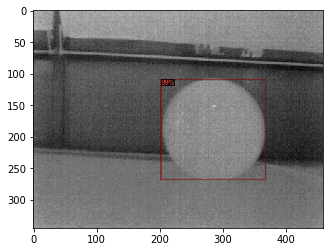

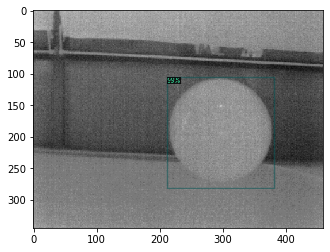

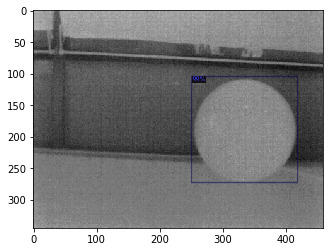

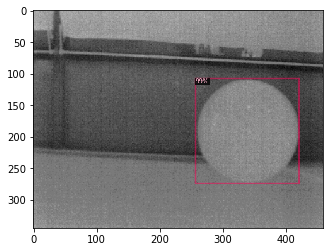

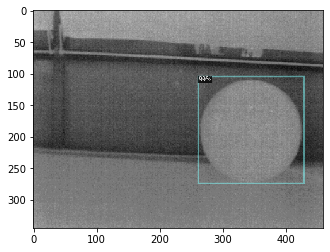

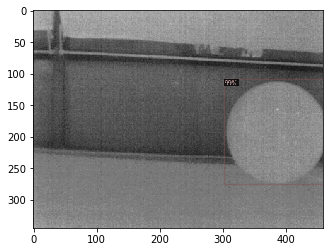

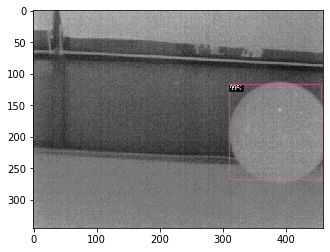

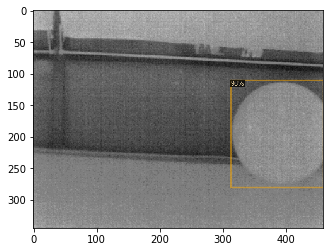

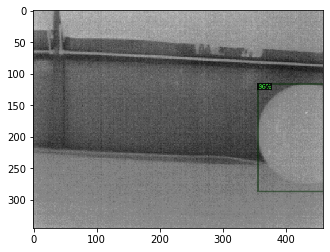

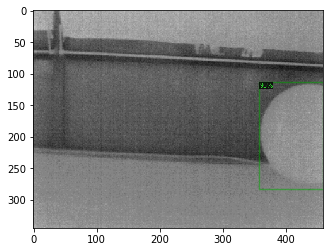

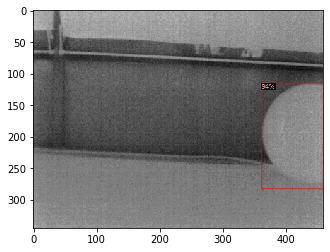

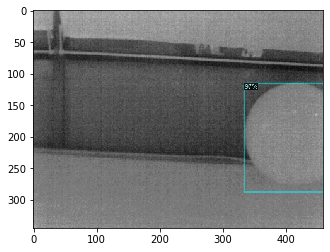

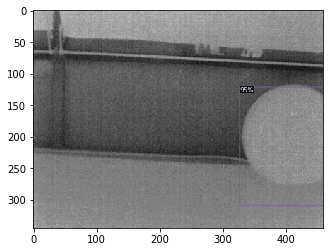

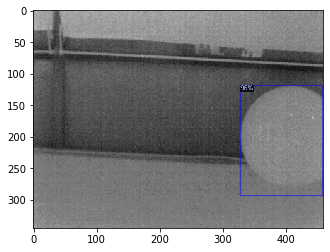

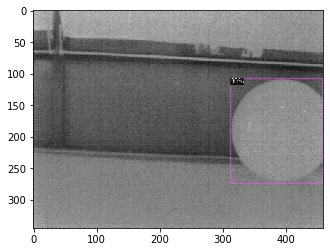

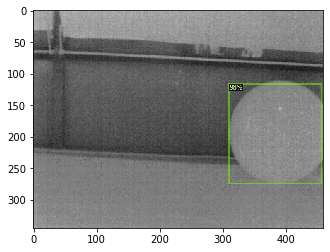

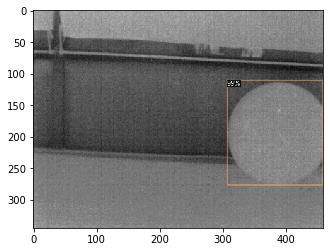

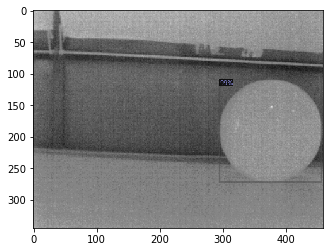

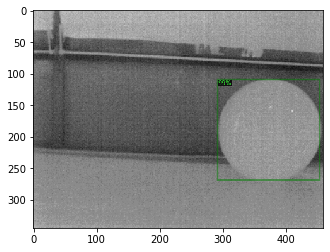

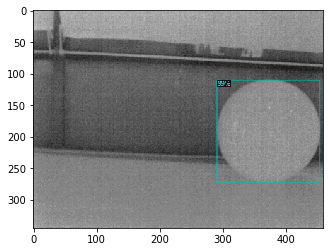

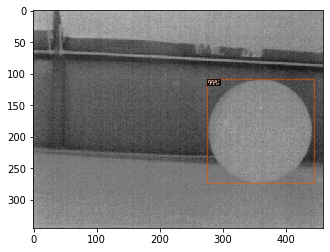

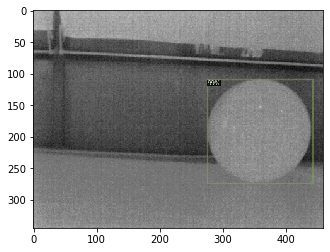

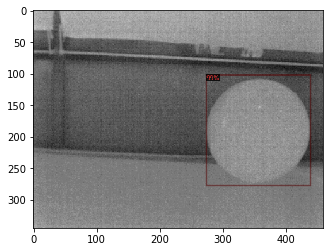

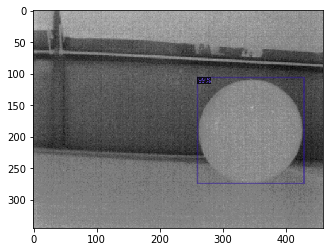

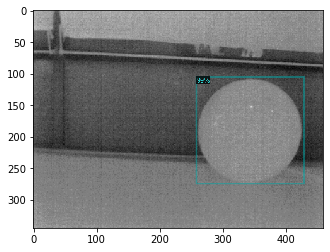

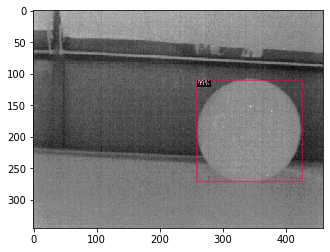

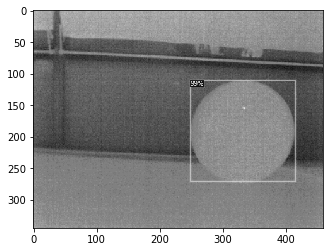

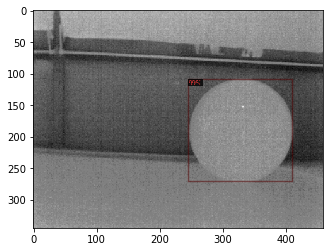

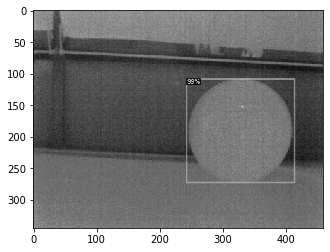

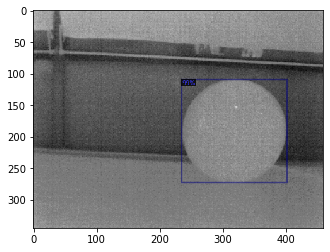

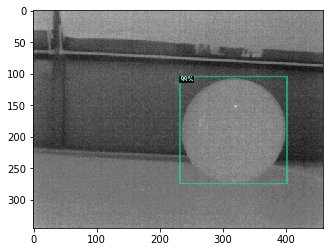

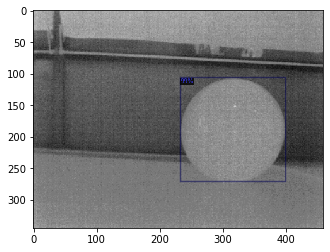

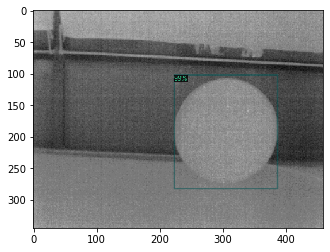

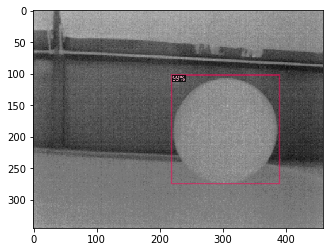

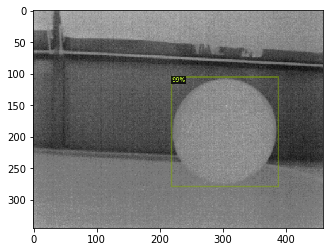

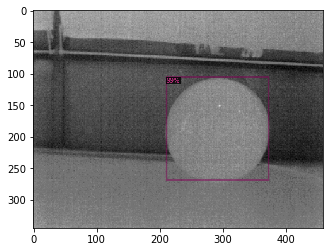

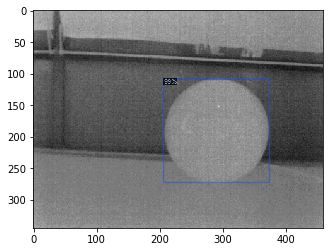

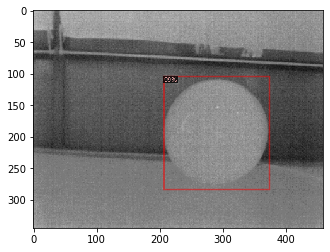

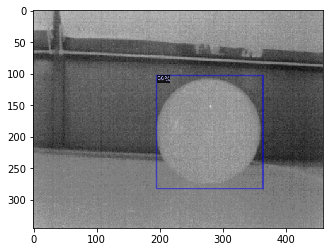

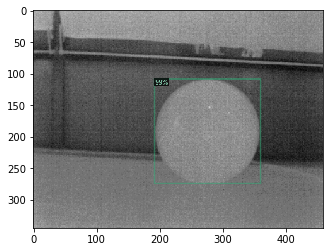

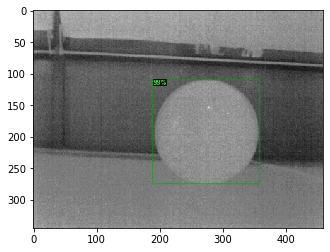

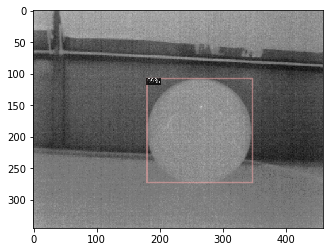

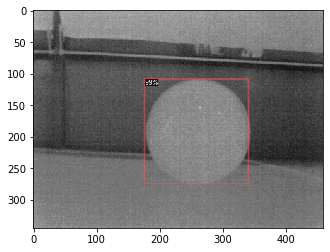

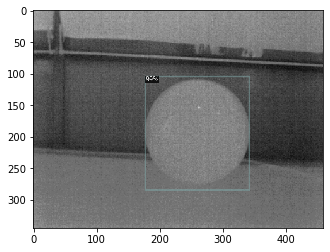

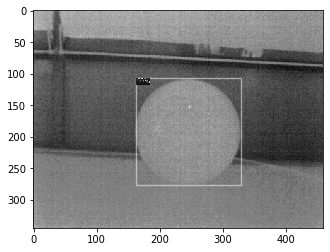

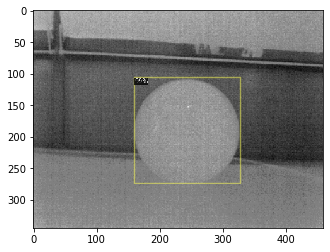

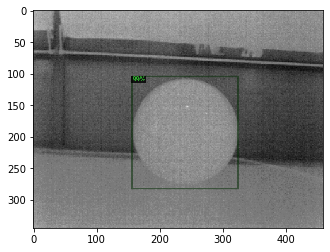

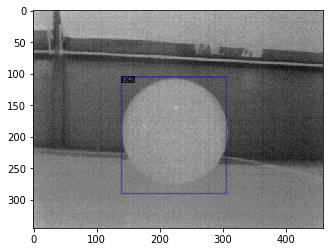

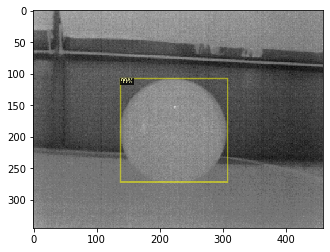

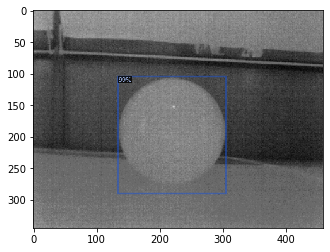

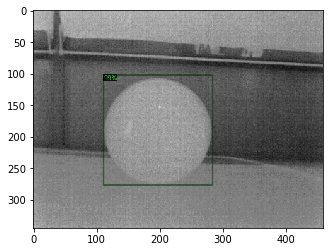

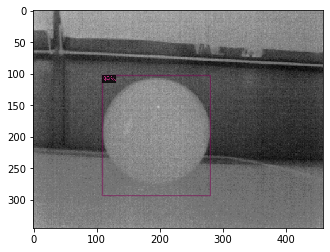

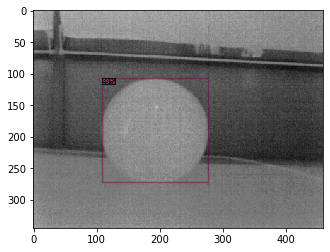

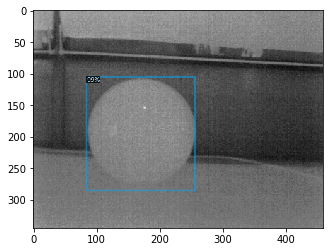

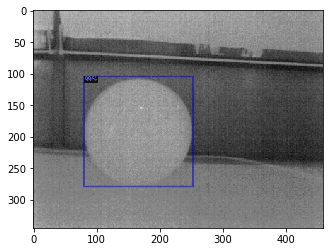

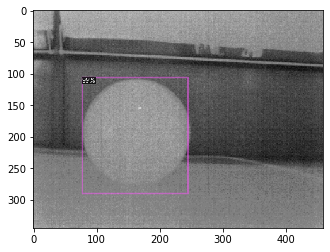

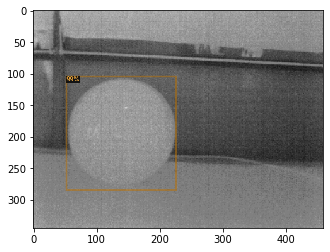

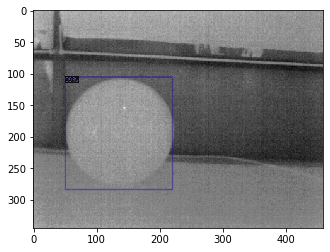

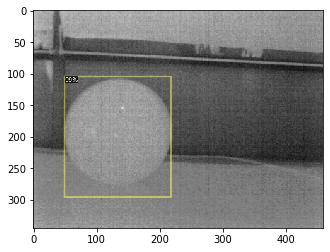

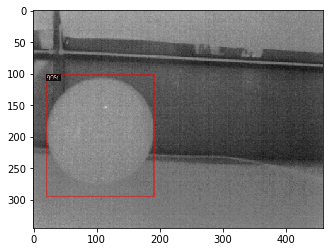

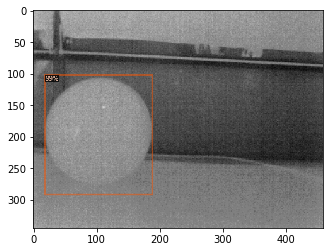

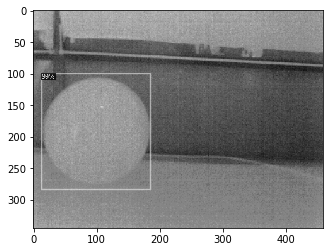

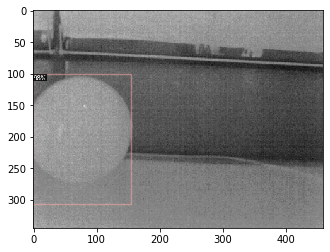

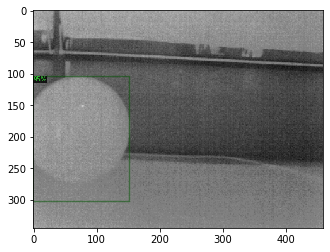

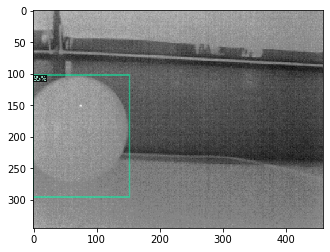

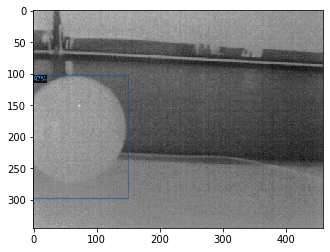

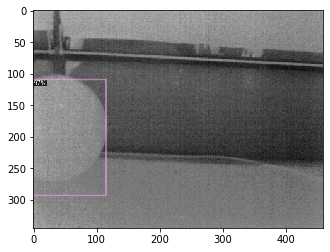

In [189]:
txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/bag2/", "bag2_ir.txt")
f = open(txt_file, "r")
txt_result = open(os.path.join("/home/danielarato/ball_detection/Datasets/train/", "results_ir.txt"),"w") 
centers=diameters=[]
Xi=Yi=Zi=[]


for line in f: 
# READ IMAGES CORRESPONDENT TO EACH LINE
    im = cv2.imread(line[:len(line)-1])
    outputs = predictor(im)
    
    results=outputs["instances"].to("cpu")


# UNCOMENT TO VISUALIZE IMAGES
    v= Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(results)
    plt.figure()
    plt.imshow(v.get_image()[:, :, ::-1])

# CALCULATE CENTERS
    if(len(results)!=0 and results.scores.numpy()[0]>0.85):
        
        coordinates=results.pred_boxes.tensor[0].numpy()
#         print(coordinates)
        xc=(coordinates[0]+coordinates[2])/2+coordinates[0]
        yc=(coordinates[3]+coordinates[1])/2+coordinates[1]
        xc=float("%0.2f"%xc)
        yc=float("%0.2f"%yc)
        centers.append([xc,yc])
        
        dx=float("%0.2f"%(float("%0.2f"%coordinates[2])-float("%0.2f"%coordinates[0])))
        dy=float("%0.2f"%(float("%0.2f"%coordinates[3])-float("%0.2f"%coordinates[1])))
        d_pix=(dx+dy)/2
        diameters.append([dx,dy]) 
        
        Z=((fx+fy)/2)*(d_real/d_pix)
        X=(Z*(xc-cx))/fx
        Y=(Z*(yc-cy))/fy
        
        Xi.append(X)
        Yi.append(Y)
        Zi.append(Z)
        
        
        txt_result.write(line[:88])
        txt_result.write(" , ")
        txt_result.write(np.array2string(coordinates))
        txt_result.write("\n")
        print(X/1000,Y/1000,Z/1000)
#         print("X1=",float("%0.2f"%coordinates[0]), " y1=",float("%0.2f"%coordinates[1])," x2=", float("%0.2f"%coordinates[2]), " y2=",float("%0.2f"%coordinates[3]),"Cx=",cx," Cy=",cy, " Dx=",dx," Dy=", dy)
txt_result.close()
f.close()



Xi=np.array(Xi)
Yi=np.array(Yi)
Zi=np.array(Zi)

    

-0.3346294418136237 1.1758200182852014 3.5293651182090966
-0.15968877795008232 1.1712628639753617 3.541870821293938
0.019255777154845048 1.1660998999036531 3.539546785367619
0.17591227752076882 1.1624637785007408 3.528768020470771
0.3422793927530279 1.1486721834509797 3.497994912950146
0.5300067373845658 1.1848409805537243 3.593452846646835
0.6936757291388479 1.1772422360940462 3.590401292147209
0.8627514538369783 1.1820676739988 3.620691096132481
1.0065323306045255 1.1734142352378074 3.6055449034745024
1.2063072843921931 1.1890208899514698 3.66458365835061
1.3592899318303528 1.181144529888738 3.664540736477781
1.4790042846039892 1.164667376945874 3.6517946566016155
1.645199410946641 1.183130489450707 3.6881266385208415
1.7635588565751597 1.1699786722639487 3.694746799704771
1.8863436006919194 1.1695991678307145 3.6932203151626037
2.026163033767285 1.1756152037791423 3.717310541061711
2.1564774709333223 1.1701634548974764 3.721156995194995
2.2995116954947203 1.1839546576623676 3.757715

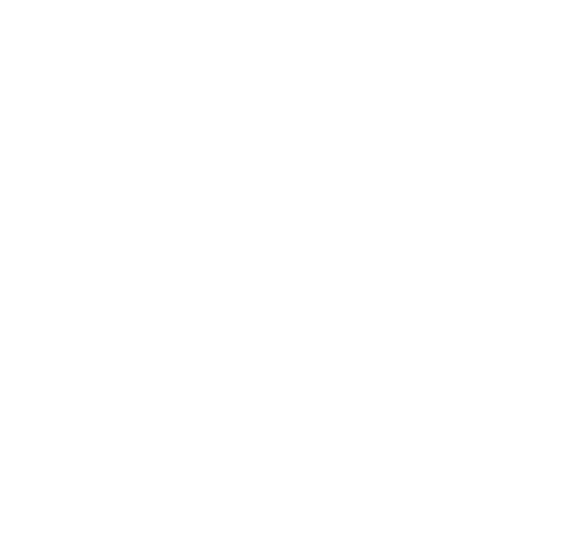

In [11]:
from mpl_toolkits.mplot3d import Axes3D

txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/bag2/", "bag2_rgb.txt")
f_rgb = open(txt_file_rgb, "r")
txt_result_rgb = open(os.path.join("/home/danielarato/ball_detection/Datasets/train/", "results_rgb.txt"),"w") 
centers_rgb=diameters_rgb=[]

_, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
X=Y=Z=[]

for line_rgb in f_rgb: 
# READ IMAGES CORRESPONDENT TO EACH LINE
    im_rgb = cv2.imread(line_rgb[:len(line_rgb)-1])
#     plt.imshow(im_rgb)
    outputs_rgb = predictor(im_rgb)


# GET BOUNDING BOXES
    results_rgb=outputs_rgb["instances"].to("cpu")
    
# UNCOMENT TO VISUALIZE IMAGES    
#     v_rgb = Visualizer(im_rgb[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#     v_rgb = v_rgb.draw_instance_predictions(results_rgb)
#     plt.figure()
#     plt.imshow(v_rgb.get_image()[:, :, ::-1])
    
# CALCULATE CENTERS    
    if(len(results_rgb)!=0):
        coordinates_rgb=results_rgb.pred_boxes.tensor[0].numpy()
        xc_rgb=(coordinates_rgb[0]+coordinates_rgb[2])/2+coordinates_rgb[0]
        yc_rgb=(coordinates_rgb[3]+coordinates_rgb[1])/2+coordinates_rgb[1]
        xc_rgb=float("%0.2f"%xc_rgb)
        yc_rgb=float("%0.2f"%yc_rgb)
        centers_rgb.append([xc_rgb,yc_rgb])
        
        dx_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[2])-float("%0.2f"%coordinates_rgb[0])))
        dy_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[3])-float("%0.2f"%coordinates_rgb[1])))
        d_pix_rgb=(dx_rgb+dy_rgb)/2
        diameters_rgb.append([dx_rgb,dy_rgb]) 
        
        Z_rgb=((fx_rgb+fy_rgb)/2)*(d_real/d_pix_rgb)
        X_rgb=(Z_rgb*(xc_rgb-cx_rgb))/fx_rgb
        Y_rgb=(Z_rgb*(yc_rgb-cy_rgb))/fy_rgb
        X.append(X_rgb)
        Y.append(Y_rgb)
        Z.append(Z_rgb)
        
        
        txt_result_rgb.write(line_rgb[:88])
        txt_result_rgb.write(" , ")
        txt_result_rgb.write(np.array2string(coordinates_rgb))
        txt_result_rgb.write("\n")
        print(X_rgb/1000,Y_rgb/1000,Z_rgb/1000)
#         print("X1=",float("%0.2f"%coordinates[0]), " y1=",float("%0.2f"%coordinates[1])," x2=", float("%0.2f"%coordinates[2]), " y2=",float("%0.2f"%coordinates[3]),"Cx=",cx," Cy=",cy, " Dx=",dx," Dy=", dy)
txt_result_rgb.close()
f_rgb.close()


X=np.array(X)
Y=np.array(Y)
Z=np.array(Z)


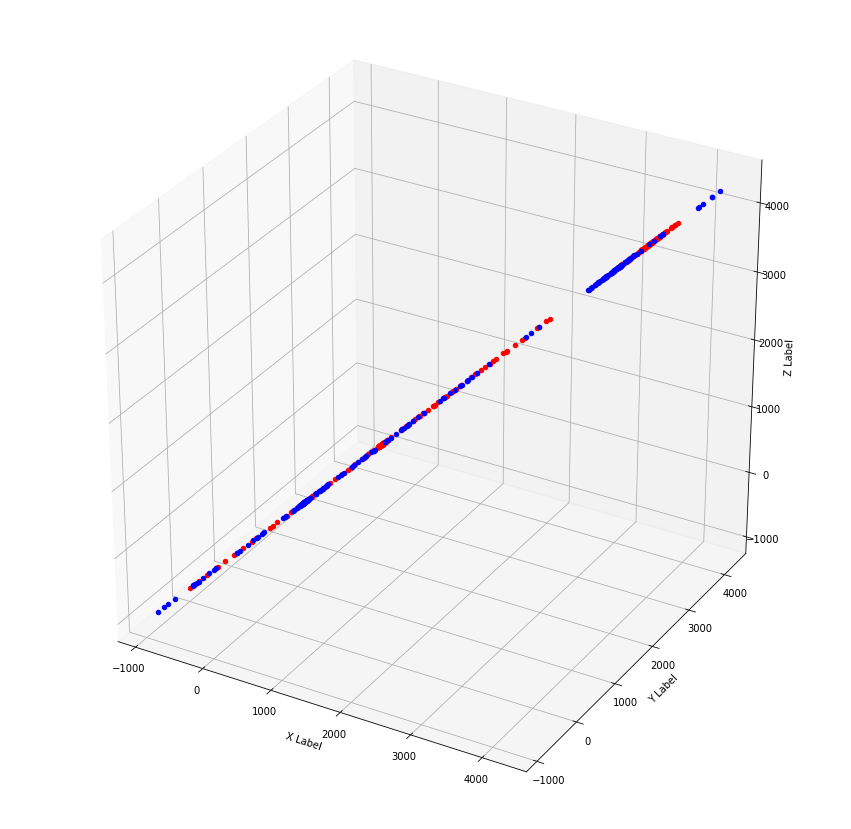

In [12]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d' )

ax.scatter(X, Y, Z, c='r', depthshade=False)
ax.scatter(Xi, Yi, Zi, c='b', depthshade=False)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

147.77113 147.77113 143.48048
146.29007 146.29007 143.59358
146.3557 146.3557 143.32457
147.10962 147.10962 144.49124
149.81967 149.81967 147.53198
147.43874 147.43874 146.01477
143.54263 143.54263 138.87871
147.21184 147.21184 141.37009
146.59122 146.59122 144.29416
148.99931 148.99931 143.97906
133.1094 133.1094 131.53694
137.77176 137.5146 137.77176
139.48059 134.11728 139.48059
142.41273 142.41273 138.86377
142.82684 142.82684 137.71182
141.1291 141.1291 138.74982
140.01808 140.01808 137.93346
141.48553 141.48553 141.13385
140.84561 140.84561 137.56526
139.00375 139.00375 137.86261
140.3996 140.3996 138.40134
143.92041 143.92041 142.19055
141.6431 140.17828 141.6431
141.83173 141.83173 141.73279
146.87726 146.87726 140.30595
153.69064 153.69064 146.46219
145.74794 145.74794 140.68675
148.83041 148.83041 142.19803
145.04579 145.04579 140.12376
147.29109 147.29109 142.31233
146.38782 146.38782 144.64095
146.70824 146.70824 140.92677
143.49551 143.49551 142.4411
142.13513 142.13513 13

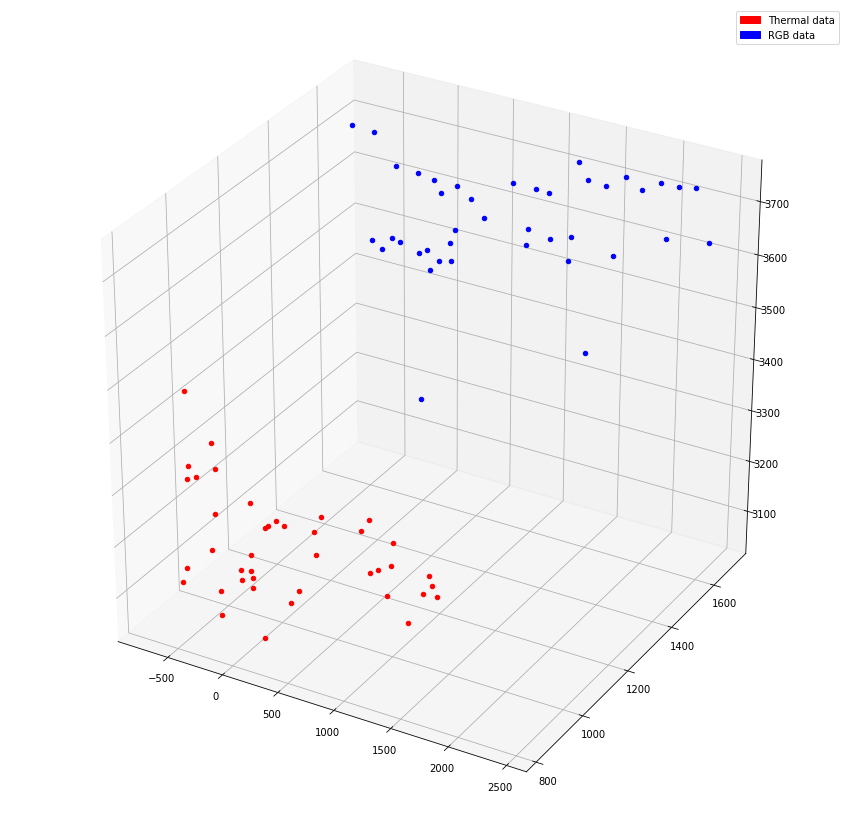

In [18]:
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
#read txt files with image path
# txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/bag2/", "bag2_rgb.txt")
txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "RGB_camera.txt")

f_rgb = open(txt_file_rgb, "r")

txt_file_ir = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "IR_camera.txt")
f_ir = open(txt_file_ir, "r")

#iniciate 3d plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d' )
blue_patch = mpatches.Patch(color='blue', label='RGB data')
red_patch = mpatches.Patch(color='red', label='Thermal data')
plt.legend(handles=[red_patch,blue_patch])

#initiate vectors
Xt=[]
Yt=[]
Zt=[]
Xr=[]
Yr=[]
Zr=[]
xpi=[]
ypi=[]
xpr=[]
ypr=[]
c=0

#for each figure in the path
for line_rgb in f_rgb: 
# read images and calculate detected bounding box for each camera
    im_rgb = cv2.imread(line_rgb[:len(line_rgb)-1])
    outputs_rgb = predictor(im_rgb)
    results_rgb=outputs_rgb["instances"].to("cpu")
    
    line_ir=f_ir.readline()
    im_ir = cv2.imread(line_ir[:len(line_ir)-1])
    outputs_ir = predictor(im_ir)
    results_ir=outputs_ir["instances"].to("cpu")

# CALCULATE CENTERS - remove images without detection in both timestamp
    if(len(results_rgb)!=0 and len(results_ir)!=0 ):
        coordinates_ir=results_ir.pred_boxes.tensor[0].numpy()
        coordinates_rgb=results_rgb.pred_boxes.tensor[0].numpy()
        
        cond1=(abs((coordinates_rgb[2]-coordinates_rgb[0])-(coordinates_rgb[3]-coordinates_rgb[1]))>=0.05*max((coordinates_rgb[2]-coordinates_rgb[0]),(coordinates_rgb[3]-coordinates_rgb[1])))
        cond2=(abs((coordinates_ir[2]-coordinates_ir[0])-(coordinates_ir[3]-coordinates_ir[1]))>=0.05*max((coordinates_ir[2]-coordinates_ir[0]),(coordinates_ir[3]-coordinates_ir[1])))

        if(cond1==False and cond2==False):
            #VISUAL
            xc_rgb=(coordinates_rgb[0]+coordinates_rgb[2])/2+coordinates_rgb[0]
            yc_rgb=(coordinates_rgb[3]+coordinates_rgb[1])/2+coordinates_rgb[1]
            xc_rgb=float("%0.2f"%xc_rgb)
            yc_rgb=float("%0.2f"%yc_rgb)

            dx_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[2])-float("%0.2f"%coordinates_rgb[0])))
            dy_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[3])-float("%0.2f"%coordinates_rgb[1])))
            d_pix_rgb=(dx_rgb+dy_rgb)/2

            Z_rgb=((fx_rgb+fy_rgb)/2)*(d_real/d_pix_rgb)
            X_rgb=(Z_rgb*(xc_rgb-cx_rgb))/fx_rgb
            Y_rgb=(Z_rgb*(yc_rgb-cy_rgb))/fy_rgb

            ax.scatter(X_rgb, Y_rgb, Z_rgb, c='b') #draw in plot
            #IR
            xc=(coordinates_ir[0]+coordinates_ir[2])/2+coordinates_ir[0]
            yc=(coordinates_ir[3]+coordinates_ir[1])/2+coordinates_ir[1]
            xc=float("%0.2f"%xc)
            yc=float("%0.2f"%yc)

            dx=float("%0.2f"%(float("%0.2f"%coordinates_ir[2])-float("%0.2f"%coordinates_ir[0])))
            dy=float("%0.2f"%(float("%0.2f"%coordinates_ir[3])-float("%0.2f"%coordinates_ir[1])))
            d_pix=(dx+dy)/2

            Z_ir=((fx+fy)/2)*(d_real/d_pix)
            X_ir=(Z_ir*(xc-cx))/fx
            Y_ir=(Z_ir*(yc-cy))/fy

            #append points
            xpr.append(xc_rgb)
            ypr.append(yc_rgb)
            xpi.append(xc)
            ypi.append(yc)
            Xr.append(X_rgb)
            Yr.append(Y_rgb)
            Zr.append(Z_rgb)
            Xt.append(X_ir)
            Yt.append(Y_ir)
            Zt.append(Z_ir)        

            ax.scatter(X_ir, Y_ir, Z_ir, c='r') #draw in plot
            
            c+=1

            print(max((coordinates_ir[2]-coordinates_ir[0]),(coordinates_ir[3]-coordinates_ir[1])),(coordinates_ir[2]-coordinates_ir[0]),coordinates_ir[3]-coordinates_ir[1])


        
f_ir.close()        
f_rgb.close()
print(c)

In [19]:
objectPoints1=np.array([Xr,Yr,Zr]).T
objectPoints2=np.array([Xt,Yt,Zt]).T
(objectPoints1).shape
# print(len(Xr))
print (len(objectPoints1))


41


In [33]:
retval, Rt, inliers=cv2.estimateAffine3D(objectPoints1,objectPoints2,confidence=0.7)
# Rt=np.concatenate([Rt.T,np.array([0,0,0,1])])
Rt=np.vstack([Rt,np.array([0,0,0,1])])
print(inliers.T)
print(Rt)


[[0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0]]
[[ 1.27873334e+00  1.20716861e+01 -7.95574789e+00  8.22905995e+03]
 [ 1.60576631e-02 -4.32289901e+00  1.34062069e+00  3.11690248e+03]
 [-6.15874349e-02 -1.17427926e+01  4.79980490e+00  5.24711777e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [23]:
objectPoints_mult=np.concatenate([objectPoints2, np.ones((len(objectPoints1), 1))], axis=1)
rotatedPoints= (Rt @ objectPoints_mult.T).T
print (objectPoints_mult.T.shape)

(4, 41)


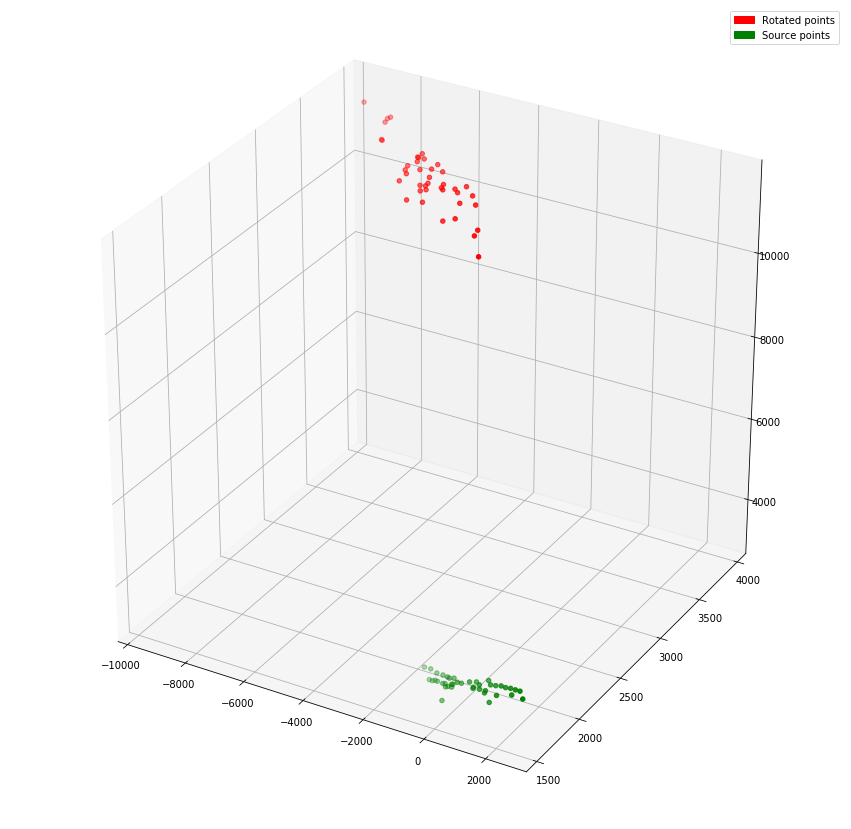

In [24]:
fig2 = plt.figure(figsize=(15,15))
ax2 = fig2.add_subplot(111, projection='3d' )
blue_patch = mpatches.Patch(color='green', label='Source points')
red_patch = mpatches.Patch(color='red', label='Rotated points')
plt.legend(handles=[red_patch,blue_patch])


ax2.scatter(rotatedPoints[:,0],rotatedPoints[:,1],rotatedPoints[:,2], c='r')
ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='g')